## Description
This is the cross correlation calculation result. The result should show below in the first graph (ignore the first 2). You might need to invoke the cell below here to see the graph.

In [133]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


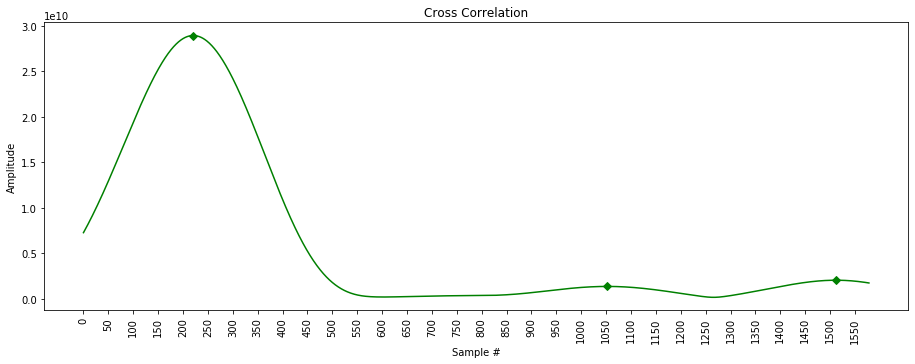

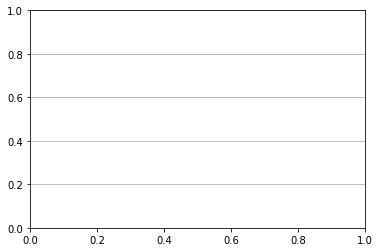

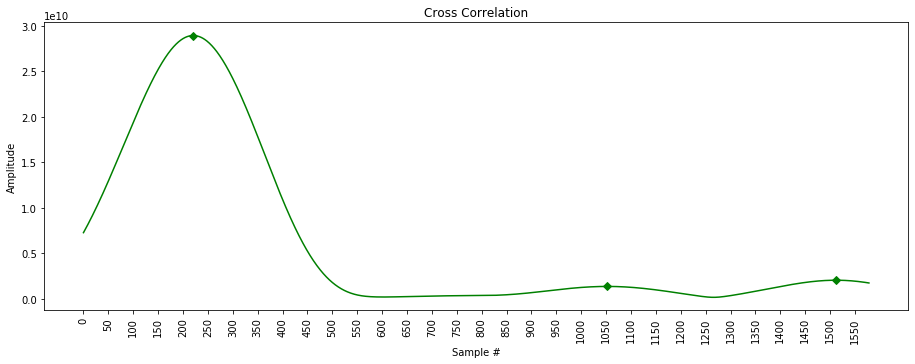

In [136]:
%matplotlib inline

import matplotlib.pyplot as plt
import analysis
import cross_correlation_analyzer as cca
import numpy as np
from scipy import signal

threshold = 1e4
sample_number = 1

# analysis.show_recording(sample_number)
# analysis.show_cross_correlation(sample_number)

cc = cca.main(sample_number)
analysis.get_graph_figure(cc, 'Cross Correlation', markers=list(signal.find_peaks(cc)[0]))
